### Set directories

In [1]:
import os
import re
from glob import glob
basedir = os.getcwd()
print(basedir)

names = []
names += glob(os.path.join(basedir, 'HRTF/IRC_*'))
print(names[0])

splitnames = [os.path.split(name) for name in names]
print(len(splitnames))

p = re.compile('IRC_\d{4,4}')
print(p)

subjects = [int(name[4:8]) for base, name in splitnames 
                         if not (p.match(name[-8:]) is None)]
print(subjects)

C:\Users\mynam\Documents\GitHub\Simultaneous-Sound-Localisation-Transformer
C:\Users\mynam\Documents\GitHub\Simultaneous-Sound-Localisation-Transformer\HRTF\IRC_1002
1
re.compile('IRC_\\d{4,4}')
[1002]


### load data from .mat files

In [2]:
from scipy.io import loadmat

k = 0
subject = subjects[k]

for k in range(len(names)):
    subject = subjects[k]
    # filename = os.path.join(names[k], 'IRC_' + str(subject))
    filename = os.path.join(names[k], 'COMPENSATED/MAT/HRIR/IRC_' + str(subject) + '_C_HRIR.mat')
#     print(filename)

### Create labels (azimuth, elevation)

dict_keys(['__header__', '__version__', '__globals__', 'r_eq_hrir_S', 'l_eq_hrir_S'])
[('elev_v', 'O'), ('azim_v', 'O'), ('type_s', 'O'), ('sampling_hz', 'O'), ('content_m', 'O')]
(187, 2)
(2, 187, 512)


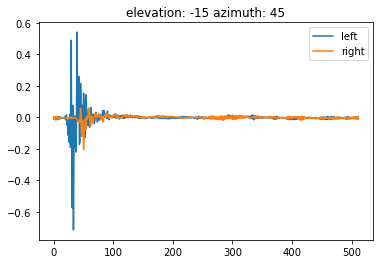

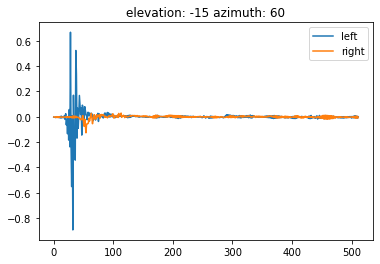

In [3]:
import numpy as np
import matplotlib.pyplot as plt 

m = loadmat(filename, struct_as_record=True)
print(m.keys())
print(m['l_eq_hrir_S'].dtype)

l, r = m['l_eq_hrir_S'], m['r_eq_hrir_S']
hrirSet_l = l['content_m'][0][0]
hrirSet_r = r['content_m'][0][0]
elev = l['elev_v'][0][0]
azim = l['azim_v'][0][0]

label = np.hstack((elev, azim))
print(label.shape)

# 0: left-ear 1: right-ear
hrirSet = np.vstack((np.reshape(hrirSet_l, (1,) + hrirSet_l.shape),
                          np.reshape(hrirSet_r, (1,) + hrirSet_r.shape)))
print(hrirSet.shape)

for i in range(51,53):
    plt.plot(hrirSet[0, i, :])
    plt.plot(hrirSet[1, i, :])
    plt.legend(['left','right'], loc='best')
    plt.title('elevation: '+str(label[i, 0])+' azimuth: '+str(label[i, 1]))
    
    plt.show()


### Convolve audio signals with left-ear and right-ear HRIR

Input:

- mono-track audio signal

Output:

- left-ear and right-ear time sequence pairs

In [4]:
import soundfile as sf
from random import gauss

print(basedir)
path = glob(os.path.join(basedir, 'audio/*'))
print(path)

# left-ear and right-ear signal pairs
sigPairSet = []
audioIndex = -1
noiseIntensityLeft = 1
noiseIntensityRight = 1

for audioPath in path:
    audioIndex += 1
    data, sampleRate = sf.read(audioPath)
    print(data.shape)
    # audioSliceList = [range(sampleRate//1*i, sampleRate//1*(i+1)) for i in range(1, data.shape[-1]//(sampleRate//1))]
    audioSliceList = [range(sampleRate*i, sampleRate*(i+1)) for i in range(3)]
    sliceIndex = -1
    
    for audioSlice in audioSliceList:
        sliceIndex += 1
        audio = data[audioSlice]
        lenAfterConv = hrirSet.shape[2]+audio.size-1
        print(len(audioSlice))
        # shape after convolution: 512 + audio length - 1
        sigPair = np.zeros((hrirSet.shape[0], hrirSet.shape[1], lenAfterConv))
        print(sigPair.shape)


        # hrirSet is of shape (2, 187, 512)
        for i in range(hrirSet.shape[1]):
            sigLeft = np.convolve(audio, hrirSet[0][i])
            sigRight = np.convolve(audio, hrirSet[1][i])

            sigLeft = sigLeft.reshape(1, sigLeft.shape[0])
            sigRight = sigRight.reshape(1, sigRight.shape[0])
            noiseLeft = [noiseIntensityLeft * gauss(0.0, 1.0) for _ in range(lenAfterConv)]
            noiseRight = [noiseIntensityRight * gauss(0.0, 1.0) for _ in range(lenAfterConv)]

            sigPair[0][i] = sigLeft #+ noiseLeft
            sigPair[1][i] = sigRight #+ noiseRight
    
        sigPairSet.append(sigPair)

# (slice no., left/right, 187 locations, signal length)
sigPairSet = np.array(sigPairSet)
tempShape = sigPairSet.shape

sigPairSet = sigPairSet.reshape((tempShape[0],tempShape[2],tempShape[1],tempShape[3]))
print(sigPairSet.shape)


C:\Users\mynam\Documents\GitHub\Simultaneous-Sound-Localisation-Transformer
['C:\\Users\\mynam\\Documents\\GitHub\\Simultaneous-Sound-Localisation-Transformer\\audio\\music-fma-0001.wav']
(3488705,)
16000
(2, 187, 16511)
16000
(2, 187, 16511)
16000
(2, 187, 16511)
(3, 187, 2, 16511)


### Windowed FFT

Input:

- left-ear and right-ear time sequences

Output:

- left-ear and right-ear time-varying spectra



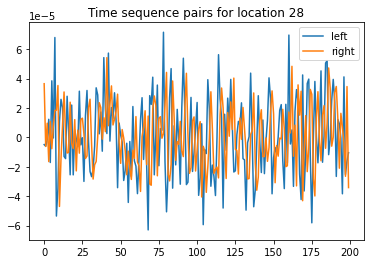

16000
(501, 35)


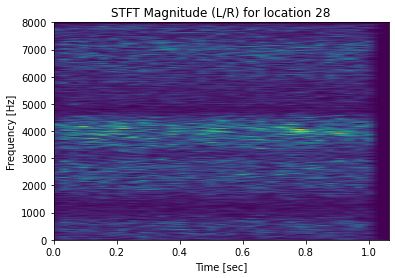

In [124]:
# visualise left-ear and right-ear signal pairs and their spectrogram
from scipy import signal
import random

randomExample = 1
randomLoc = random.randint(0,186)
plt.plot(sigPairSet[randomExample, randomLoc, 0, 200:400])
plt.plot(sigPairSet[randomExample, randomLoc, 1, 200:400])
plt.title('Time sequence pairs for location '+str(randomLoc))
plt.legend(['left','right'])
plt.show()

fs = sampleRate
print(fs)

f, t, Zxx = signal.stft(sigPairSet[randomExample, randomLoc, 0], fs, nperseg=1000)
print(Zxx.shape)

plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude (L/R) for location '+str(randomLoc))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
def cartesian2euler(val):
    x = val.real
    y = val.imag
    
    r = np.sqrt(x**2+y**2)
    if x != 0:
        theta = np.arctan(y/x)
    else:
        theta = np.pi/2
        
    return r, theta

def calIPD(seqL, seqR):
    temp = np.divide(seqL, seqR, out=np.zeros_like(seqL), where=seqR!=0)
    ipd = np.arctan(np.divide(np.imag(temp), np.real(temp), out=np.zeros_like(np.real(temp)), where=np.real(temp)!=0))
    return ipd

In [144]:
# calculate spectral and IPD cues
spectralCues = np.zeros(sigPairSet.shape[:-2] + Zxx.shape + (4,), dtype='float')
ipdCues = np.zeros(sigPairSet.shape[:-2] + Zxx.shape, dtype='float')

for i in range(sigPairSet.shape[0]):
    sigPair = sigPairSet[i]
    print(sigPair.shape)
    
    for locIndex in range(sigPair.shape[0]):
        f_l, t_l, Zxx_l = signal.stft(sigPair[locIndex, 0], fs, nperseg=1000)
        f_r, t_r, Zxx_r = signal.stft(sigPair[locIndex, 1], fs, nperseg=1000)
#         print(Zxx_l.shape)
        
        ipdCues[i, locIndex,:] = calIPD(Zxx_l, Zxx_r)
        
        for freqIndex in range(Zxx_l.shape[0]):
            for timeIndex in range(Zxx_l.shape[1]):
                temp=[]
                r_l, theta_l = cartesian2euler(Zxx_l[freqIndex][timeIndex])
                r_r, theta_r = cartesian2euler(Zxx_r[freqIndex][timeIndex])
                spectralCues[i, locIndex, freqIndex, timeIndex] = np.array([r_l, theta_l, r_r, theta_r])
#                 print(spectralCues[i, locIndex, freqIndex, timeIndex])
                
        

(187, 2, 16511)
(187, 2, 16511)
(187, 2, 16511)


In [162]:
print("Size of feature matrices:")
print(ipdCues.shape)
print(spectralCues.shape)

Size of feature matrices:
(3, 187, 501, 35)
(3, 187, 501, 35, 4)


### Data visualisation

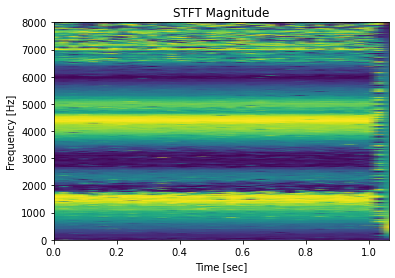

In [154]:
# IPD visualisation

# plt.plot(ipdCues[0,0,100:105,:])

plt.pcolormesh(t_l, f_l, np.abs(ipdCues[0,random.randint(0,186)]), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show() 

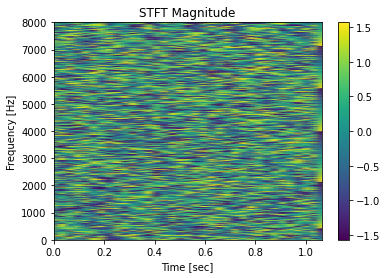

In [169]:
plt.pcolormesh(t, f, spectralCues[0,random.randint(0,186),:,:,3], shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.show()


### Feature extraction

- IPD cues (similar as ITD (ambiguous at high frequencies))

  arg(S_l/S_r)
  
  
- Spectral cues (essentially tells about ILD cues)

  do STFT and then convert it to magnitude and phase

### Load data from .wav files (discarded)

In [23]:
import wave
import numpy as np


def _wav2array(nchannels, sampwidth, data):
    """data must be the string containing the bytes from the wav file."""
    num_samples, remainder = divmod(len(data), sampwidth * nchannels)
    if remainder > 0:
        raise ValueError('The length of data is not a multiple of '
                         'sampwidth * num_channels.')
    if sampwidth > 4:
        raise ValueError("sampwidth must not be greater than 4.")

    if sampwidth == 3:
        a = np.empty((num_samples, nchannels, 4), dtype=np.uint8)
        raw_bytes = np.frombuffer(data, dtype=np.uint8)
        a[:, :, :sampwidth] = raw_bytes.reshape(-1, nchannels, sampwidth)
        a[:, :, sampwidth:] = (a[:, :, sampwidth - 1:sampwidth] >> 7) * 255
        result = a.view('<i4').reshape(a.shape[:-1])
    else:
        # 8 bit samples are stored as unsigned ints; others as signed ints.
        dt_char = 'u' if sampwidth == 1 else 'i'
        a = np.frombuffer(data, dtype='<%s%d' % (dt_char, sampwidth))
        result = a.reshape(-1, nchannels)
    return result


def readwav(file):
    """
    Read a wav file.
    Returns the frame rate, sample width (in bytes) and a numpy array
    containing the data.
    This function does not read compressed wav files.
    """
    wav = wave.open(file)
    rate = wav.getframerate()
    nchannels = wav.getnchannels()
    sampwidth = wav.getsampwidth()
    nframes = wav.getnframes()
    data = wav.readframes(nframes)
    wav.close()
    array = _wav2array(nchannels, sampwidth, data)
    return rate, sampwidth, array


def writewav24(filename, rate, data):
    """Create a 24 bit wav file.
    data must be "array-like", either 1- or 2-dimensional.  If it is 2-d,
    the rows are the frames (i.e. samples) and the columns are the channels.
    The data is assumed to be signed, and the values are assumed to be
    within the range of a 24 bit integer.  Floating point values are
    converted to integers.  The data is not rescaled or normalized before
    writing it to the file.
    Example: Create a 3 second 440 Hz sine wave.
    >>> rate = 22050  # samples per second
    >>> T = 3         # sample duration (seconds)
    >>> f = 440.0     # sound frequency (Hz)
    >>> t = np.linspace(0, T, T*rate, endpoint=False)
    >>> x = (2**23 - 1) * np.sin(2 * np.pi * f * t)
    >>> writewav24("sine24.wav", rate, x)
    """
    a32 = np.asarray(data, dtype=np.int32)
    if a32.ndim == 1:
        # Convert to a 2D array with a single column.
        a32.shape = a32.shape + (1,)
    # By shifting first 0 bits, then 8, then 16, the resulting output
    # is 24 bit little-endian.
    a8 = (a32.reshape(a32.shape + (1,)) >> np.array([0, 8, 16])) & 255
    wavdata = a8.astype(np.uint8).tostring()

    w = wave.open(filename, 'wb')
    w.setnchannels(a32.shape[1])
    w.setsampwidth(3)
    w.setframerate(rate)
    w.writeframes(wavdata)
    w.close()

In [28]:
from scipy.io import wavfile

fs, sig, array = readwav('./HRTF/IRC_1002/RAW/WAV/IRC_1002_R/IRC_1002_R_R0195_T000_P000.wav')
print(fs, sig, array.shape)
print(array[0,0])

44100 3 (8192, 2)
-2976


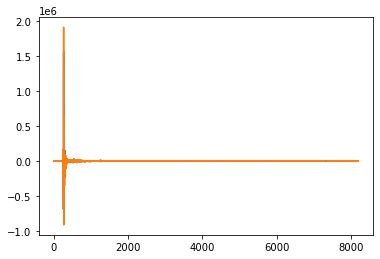

In [29]:
import matplotlib.pyplot as plt 

plt.plot(array[:,0])
plt.plot(array[:,1])
plt.show()
